In [ ]:
"""
V4 incluye doblado con FFT y suavizado con Savizky-Golay (recomendable solo p/calibraciones de baja estadística)
El archivo ".mos" o ".Asc" de entrada no debe tener encabezado
Preparando para Colab e importando librerías necesarias.
"""!pip install lmfit
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
img = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/MuestrasLuis/SSLFP_M10/4426.Asc'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit import Parameters, minimize, fit_report
from scipy.constants import *
from scipy.integrate import trapz
from scipy.signal import savgol_filter
from pathlib import Path

path= Path(img); name= path.stem; title= path.parent.name; full= path.parents[0]; print(name, title, full)

Mounted at /content/drive/
4426 SSLFP_M10 /content/drive/MyDrive/Colab-Notebooks/PyMossFit/MuestrasLuis/SSLFP_M10


Ingrese la fecha de calibración (AAAAMMDD): 20240517
Ingrese el rango de V (en mm/s): 6.085
Ingrese el número de canales: 512


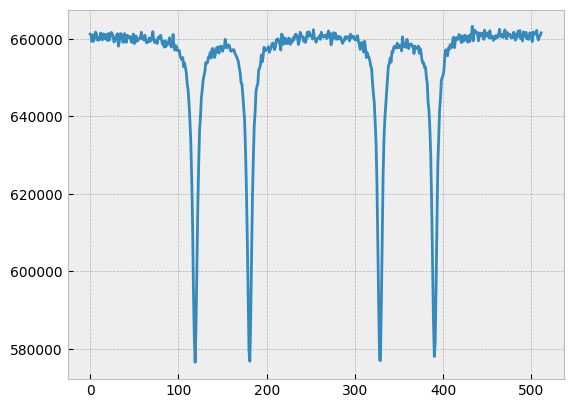

1320757


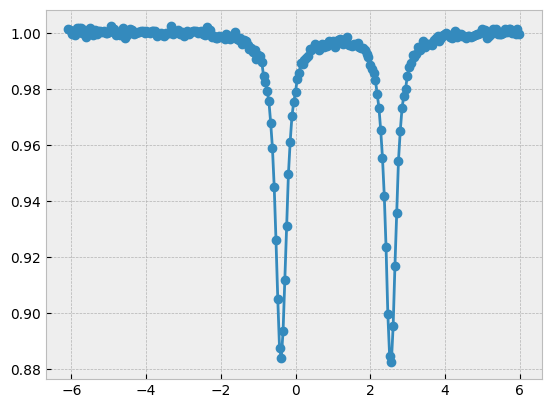

In [ ]:
"""
Para doblar, normalizar y calibrar en mm/s, los archivos del espectrómetro de CNEA de 512 canales
"""
y= np.loadtxt(img, delimiter=" "); y=y[:,1] #agregar delimiter="," o delimiter=" " en loadtxt si es de dos columnas. Caso contrario comentar y=y[:,1]
N=len(y); N2=int(N/2); N4=int(N/4)

fecha = str(input('Ingrese la fecha de calibración (AAAAMMDD): '),)
vel = float(input('Ingrese el rango de V (en mm/s): ' ), )
np.savetxt(f"{full}/{name}_calib.txt", (fecha,vel, N), fmt='%s')

#y= savgol_filter(y, 5, 2) #solo si se trata de espectro con baja estadística, comentar en otro caso
plt.plot(y)
plt.show()

"""
Doblado con FFT
"""
f= abs(np.fft.fft(y)); Nf=pd.Series(f[N2-5:N2+5]).idxmax()+(N2-5); print(Nf)
plt.plot(f[1:N])
plt.show()

for i in range(0, Nf-1):
    y[[i]]=y[[i]]+y[[N-1-i]]

y=y[0:N2-1]
"""
Normalización
"""
y2= np.concatenate([y[4:44],y[N2-50:N2-2]])

ymax=np.mean(y2)
ymax=int(ymax)

print(ymax)

for i in range(0, N2-1):
    y[[i]]=y[[i]]/ymax

x=np.arange(1,N2)

"""
de canales a escala de velocidades en mm/s
"""
v=np.loadtxt(f"{full}/{name}_calib.txt"); vmax=v[[1]]

x=np.linspace(start = 0, stop = N2-1, num= N2)

for i in range(0, N2-1):
    x[[i]]=(i-N4)*vmax/N4

x= x[0:N2-1]

plt.plot(x,y, marker="o")
plt.show()

np.savetxt(f"{full}/{name}.csv", list(zip(x,y)), delimiter=",", fmt='%1.6f')

<ipython-input-7-d9341f69bdc4>:53: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  i= trapz(1-z, x) #Las áreas de subespectros se calculan como: i= trapz(1-z, x); i1= trapz(1-z1, x)/i*100; i2=trapz(1-z2, x)/i*100; etc con z=z1+z2+...


ancho (sigma/sqrt(2)) es: 0.24 mm/s
Centroide (ISO1) es: 1.081 mm/s
Amplitud (a) es: 0.0630
Doblete es: 2.937 mm/s
área: 0.1 %
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 35
    # data points      = 255
    # variables        = 4
    chi-square         = 2.8129e-04
    reduced chi-square = 1.1207e-06
    Akaike info crit   = -3489.93534
    Bayesian info crit = -3475.77028
[[Variables]]
    b:  0.33814757 +/- 0.00177337 (0.52%) (init = 0.3)
    m:  1.08093061 +/- 6.3852e-04 (0.06%) (init = 1)
    d:  2.93685417 +/- 0.00127641 (0.04%) (init = 2.9)
    a:  0.06300930 +/- 2.3208e-04 (0.37%) (init = 0.13)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, a) = +0.6938


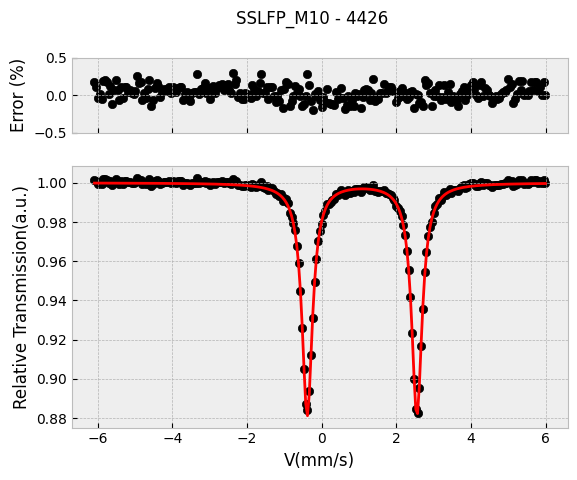

In [ ]:

"""
LECTURA DE ARCHIVO DE ENTRADA
"""
col_list=[0, 1]

x, y= np.loadtxt(f"{full}/{name}.csv", delimiter=",", usecols=col_list, unpack=True)

"""
DEFINICIÓN DE LAS FUNCIONES BASADAS EN LORENTZIANAS
"""
def singlet(a, b, m, x):
    return 2*a*b/(pi*(b**2+4*(x-m)**2))

def doublet(a, b, m, d, x):
    return 2*a*b/(pi*(b**2+4*(x-(m-d/2))**2))+2*a*b/(pi*(b**2+4*(x-(m+d/2))**2))

def sextet(a, b, m, d, q, l23, x):
    return 6*a*b/(pi*(b**2+4*(x-(m+5*d))**2))+l23*2*a*b/(pi*(b**2+4*(x-(m+3*d-q))**2))+2.5*a*b/(pi*(b**2+4*(x-(m+0.75*d))**2))+2.5*a*b/(pi*(b**2+4*(x-(m-0.75*d))**2))+l23*2*a*b/(pi*(b**2+4*(x-(m-3*d+q))**2))+6*a*b/(pi*(b**2+4*(x-(m-5*d))**2))

def linear_fitting_lmfit(params, x, y):
    b= params['b']; m= params['m']; d= params['d']; a= params['a']

    y_fit= 1-doublet(a, b, m, d, x)

    return y_fit-y

"""
AJUSTE DE LOS PARÁMETROS USANDO LOS DATOS EXPERIMENTALES
"""
params= Parameters()

params.add('b', value= 0.3, vary=True)
params.add('m', value= 1.0, vary=True)
params.add('d', value= 2.9, vary=True)
params.add('a', value= 0.13, vary=True)

fitted_params= minimize(linear_fitting_lmfit, params, args=(x, y,), method='least_square')

m= fitted_params.params['m'].value
b= fitted_params.params['b'].value
d= fitted_params.params['d'].value
a= fitted_params.params['a'].value

"""
CREACIÓN DE LOS SUBESPECTROS AJUSTADOS
"""
z= 1-doublet(a, b, m, d, x)
e= (y-z)*100

"""
INTEGRAL DE ÁREAS Y GENERACIÓN DE LOS PARÁMETROS HIPERFINOS. REPORTE EN PANTALLA
"""
i= trapz(1-z, x) #Las áreas de subespectros se calculan como: i= trapz(1-z, x); i1= trapz(1-z1, x)/i*100; i2=trapz(1-z2, x)/i*100; etc con z=z1+z2+...

b= "{0:.2f}".format(b/np.sqrt(2))
m= "{0:.3f}".format(m)
d= "{0:.3f}".format(d)
a= "{0:.4f}".format(a)
i= "{0:.1f}".format(abs(i))


print('ancho (sigma/sqrt(2)) es:', b, 'mm/s')
print('Centroide (ISO1) es:', m, 'mm/s')
print('Amplitud (a) es:', a)
print('Doblete es:', d, 'mm/s')
print('área:', i, '%')
print(fit_report(fitted_params))

"""
GRAFICA DE ESPECTROS Y SUBESPECTROS
"""
plt.style.use('bmh')

fig, (ax1, ax2) = plt.subplots(2, sharex=True, height_ratios=[1,3.5]); fig.suptitle(f"{title}" " - " f"{name}")
ax1.scatter (x, e, c= 'black')
ax1.set_ylim(-0.5,0.5)
ax1.set_ylabel('Error (%)'); #plt.axis('tight')

ax2.scatter (x, y, c= 'black')
ax2.set_xlabel('V(mm/s)')
ax2.set_ylabel('Relative Transmission(a.u.)')
ax2.plot(x, z, c='red')

plt.show()

"""
GENERACIÓN DE ARCHIVOS DE SALIDA: DATOS Y PARÁMETROS
"""
np.savetxt(f"{full}/{name}-plot.csv", list(zip(x, y, z)), delimiter=',', fmt='%1.6e')

df= pd.DataFrame ({'Ancho(mm/s)': [b], 'ISO (mm/s)': [m], 'QUAD(mm-s)': [d], 'Área(%)': [i]})
df.to_csv(f"{full}/{name}_report.csv", index=False)